In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from preg_aging.cached_reader import get_tests
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.size"] = 14
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12

In [3]:
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)

In [28]:
from preg_aging.clalit_parser import group_tests

test_groups = group_tests(tests)

### eGFR difference (eGFR formula is unreliable during pregnancy, unused)

In [35]:
from preg_aging.analyses import scr_to_egfr, scr_to_egfr_preg
from preg_aging.labnorm_utils import interp_per_age
from preg_aging.clalit_parser import get_clalit_data
scr_data = get_clalit_data("CREATININE_BLOOD").loc[-40:-1]
scr_max_ind = scr_data["qval_mean"].argmax()
scr_min_ind = scr_data["qval_mean"].argmin()
age_at_max = scr_data["age_mean"].iloc[scr_max_ind]
age_at_min = scr_data["age_mean"].iloc[scr_min_ind]
creatinine_interp = interp_per_age("CREATININE_BLOOD")
scr_max = creatinine_interp[(int(age_at_max),)](scr_data["qval_mean"].iloc[scr_max_ind])
scr_min = creatinine_interp[(int(age_at_min),)](scr_data["qval_mean"].iloc[scr_min_ind])
egfr_min = scr_to_egfr(scr_max, age_at_max)
egfr_max = scr_to_egfr(scr_min, age_at_min)
print(f"eGFR max: {egfr_max:.3f}\teGFR min: {egfr_min:.3f}\t eGFR diff: {egfr_max - egfr_min:.3f}")
print(f"Creatinine max: {scr_max:.3f}\tCreatinine min: {scr_min:.3f}\t")
print(f"Age at creatinine max: {int(age_at_max):d}\tAge at creatinine min: {int(age_at_min):d}\t")

scr_interped = np.array([creatinine_interp[tuple((k.item(),))](scr_data["qval_mean"].values[i]) for i, k in enumerate(scr_data["age_mean"].values.astype(int))])
print(scr_to_egfr_preg(scr_interped, scr_data.index.values.astype(int) + 40))

eGFR max: 129.149	eGFR min: 122.287	 eGFR diff: 6.862
Creatinine max: 0.629	Creatinine min: 0.506	
Age at creatinine max: 28	Age at creatinine min: 27	
[100.54708691 101.34143901 103.36938371 105.96661473 108.84163201
 111.96173394 117.79045337 123.12291818 128.24240024 132.38054262
 136.42614113 141.23333679 145.8909402  151.75549233 155.25421333
 158.35452887 162.27558492 165.43638943 166.69168014 168.39756357
 168.68748332 169.13630327 168.9730307  167.81532271 168.14064296
 166.40622624 165.50449591 163.37221687 159.97207183 157.74478415
 154.99877645 152.67208304 149.57949831 146.6479689  142.53358475
 139.96019486 135.50106601 132.51044193 130.18298492]


In [36]:
from preg_aging.labnorm_utils import find_median_for_lab
median_creatinine = find_median_for_lab("CREATININE_BLOOD")
creatinine_young = median_creatinine.loc[20]
creatinine_old = median_creatinine.loc[80]
egfr_young = scr_to_egfr(creatinine_young, 20)
egfr_old = scr_to_egfr(creatinine_old, 80)
print(f"eGFR young: {egfr_young:.3f}\teGFR old: {egfr_old:.3f}\teGFR diff: {egfr_young - egfr_old}")

eGFR young: 129.172	eGFR old: 78.155	eGFR diff: 51.017365893412716


KeyboardInterrupt: 

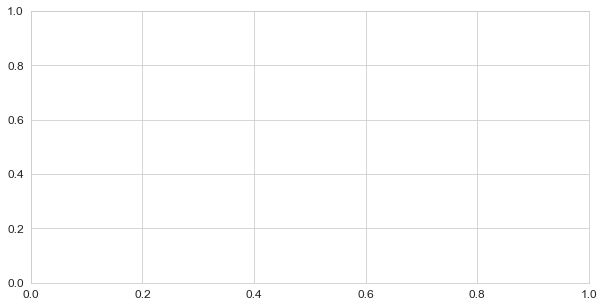

In [37]:
from preg_aging.plotting import plot_quantile_diffs_histogram
fig = plot_quantile_diffs_histogram(tests, bins=10)
fig.set_size_inches(7, 5)
fig.savefig(os.path.join("graphs", "Quantile change histogram.svg"))

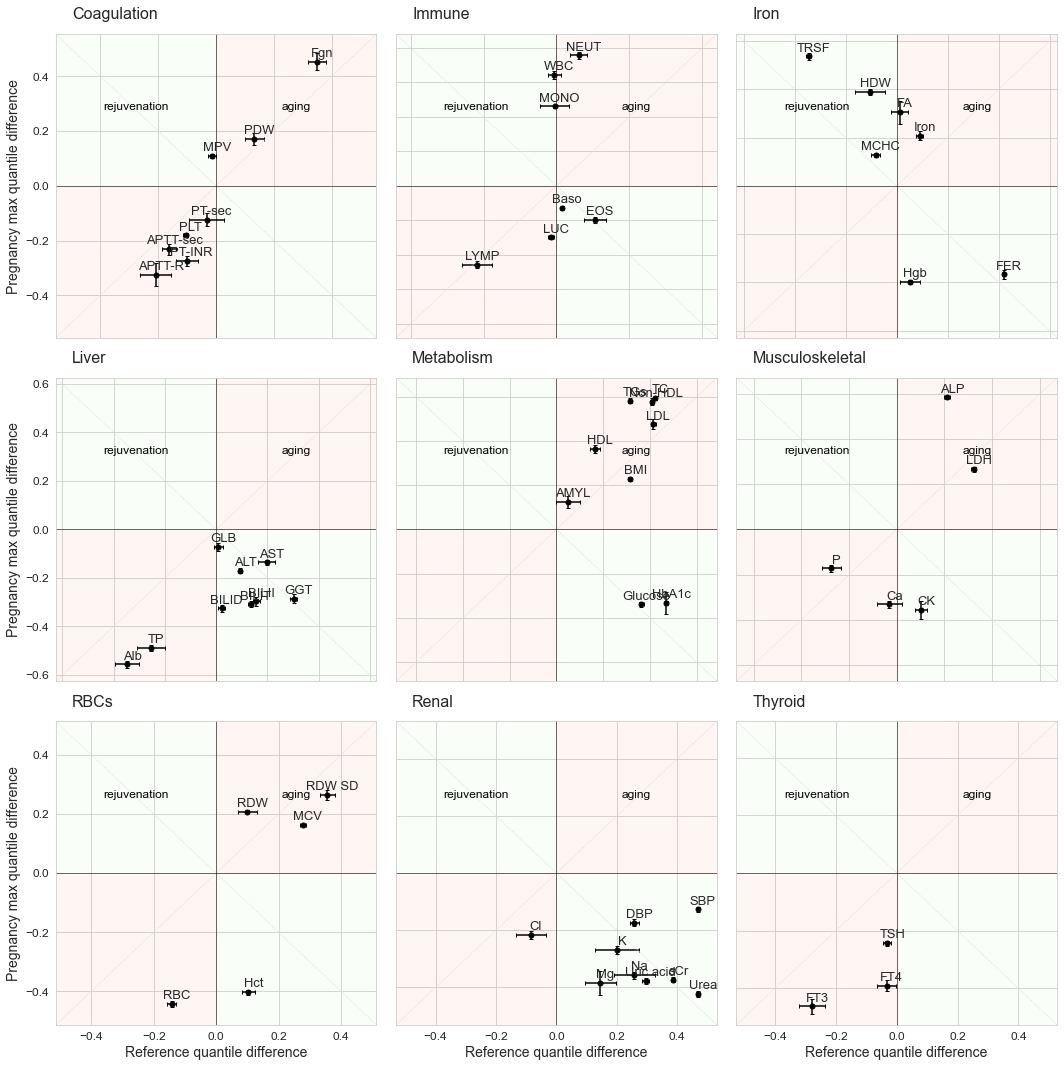

In [35]:
from preg_aging.plotting import plot_diff_grid
font_size = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 14})
age_ref = [20, 80]
fig_preg = plot_diff_grid(test_groups, labnorm_age_ref=age_ref, test_period=[-40, -2])
# fig_pp, _ = plot_diff_grid(test_groups, test_period=[0, 80])
fig_preg.tight_layout()
#fig_preg.savefig(os.path.join("graphs", f"quantile diff, preg_labnorm{str(age_ref)}.svg"))
# fig_pp.tight_layout()
# fig_pp.savefig(os.path.join("graphs", "quantile diff, pp_labnorm.pdf"))
plt.show()
plt.rcParams.update({'font.size': font_size})

## Regression training and QA

In [4]:
from preg_aging.cached_reader import get_tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from src.preg_aging.sample_dataset import resample_per_age, normalize_by_sub_div
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)
complication_tests = get_tests(True, True, True, os.path.join("csvs", "tests_complications.json"))
regression, age = resample_per_age(tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
normalized_reg = normalize_by_sub_div(regression)
model = OLS(age, add_constant(regression)).fit()
norm_model = OLS(age, add_constant(normalized_reg)).fit()
comp_reg, comp_age = resample_per_age(complication_tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
comp_model = OLS(comp_age, add_constant(comp_reg)).fit()

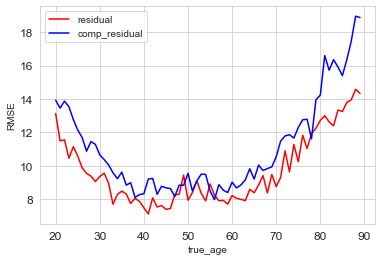

9.900145399359063


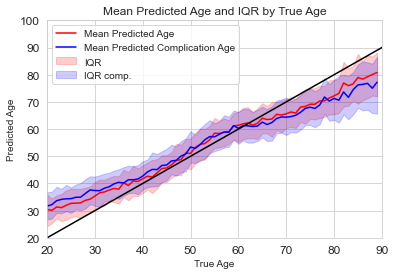

In [12]:
import matplotlib.pyplot as plt
predictions = model.predict(add_constant(regression))
resid = (predictions - age)
predictions_comp = comp_model.predict(add_constant(comp_reg))
comp_resid = (predictions_comp - comp_age)
pred_label_df = pd.DataFrame({"predicted_age": predictions, "true_age": age, "residual": resid ** 2, "predicted_comp_age": predictions_comp, "comp_residual": comp_resid ** 2})
predicted_age_group = pred_label_df.groupby("true_age")[["predicted_age", "predicted_comp_age"]]
mean_predicted_age = predicted_age_group.mean()
mse_plot = (pred_label_df.groupby("true_age")[["residual", "comp_residual"]].mean() ** 0.5).plot(ylabel="RMSE", color=["red", "blue"])
plt.show()
print(pred_label_df["residual"].mean() ** 0.5)

quants = predicted_age_group.quantile([0.25, 0.75])


plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_age"], label='Mean Predicted Age', color='red')
plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_comp_age"], label='Mean Predicted Complication Age', color='blue')
plt.plot([0,100], [0,100], color="k")

plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_age"], quants.loc[(slice(None), 0.75), "predicted_age"], color='red', alpha=0.2, label='IQR')
plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_comp_age"], quants.loc[(slice(None), 0.75), "predicted_comp_age"], color='blue', alpha=0.2, label='IQR comp.')

# Add labels and legend
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Mean Predicted Age and IQR by True Age')
plt.legend()
plt.xlim(20, 90)
plt.ylim(20, 100)
plt.show()

## Regression predictions

In [6]:
from preg_aging.analyses import sample_tests_mean_val, sample_regression_params
reps = sample_tests_mean_val(tests, 10000, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w")
params = sample_regression_params(comp_model.cov_params(), comp_model.params, reps.shape[0])
#preg_data = sample_tests_mean_val(tests, 10000, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w")

In [39]:
# pred = pd.DataFrame(data=np.einsum('ij,ij->i', add_constant(reps) - add_constant(preg_data) , params), columns=["age"], index=reps.index)
# #pred.loc[2] = 0
# import plotly.express as px
# display(px.violin(pred.reset_index(), x="week", y="age"))
# pred = pd.DataFrame(model.predict(add_constant(reps) - add_constant(preg_data)).to_numpy(), columns=["age"], index=reps.index)
# #pred.loc[2] = 0
# display(px.violin(pred.reset_index(), x="week", y="age"))

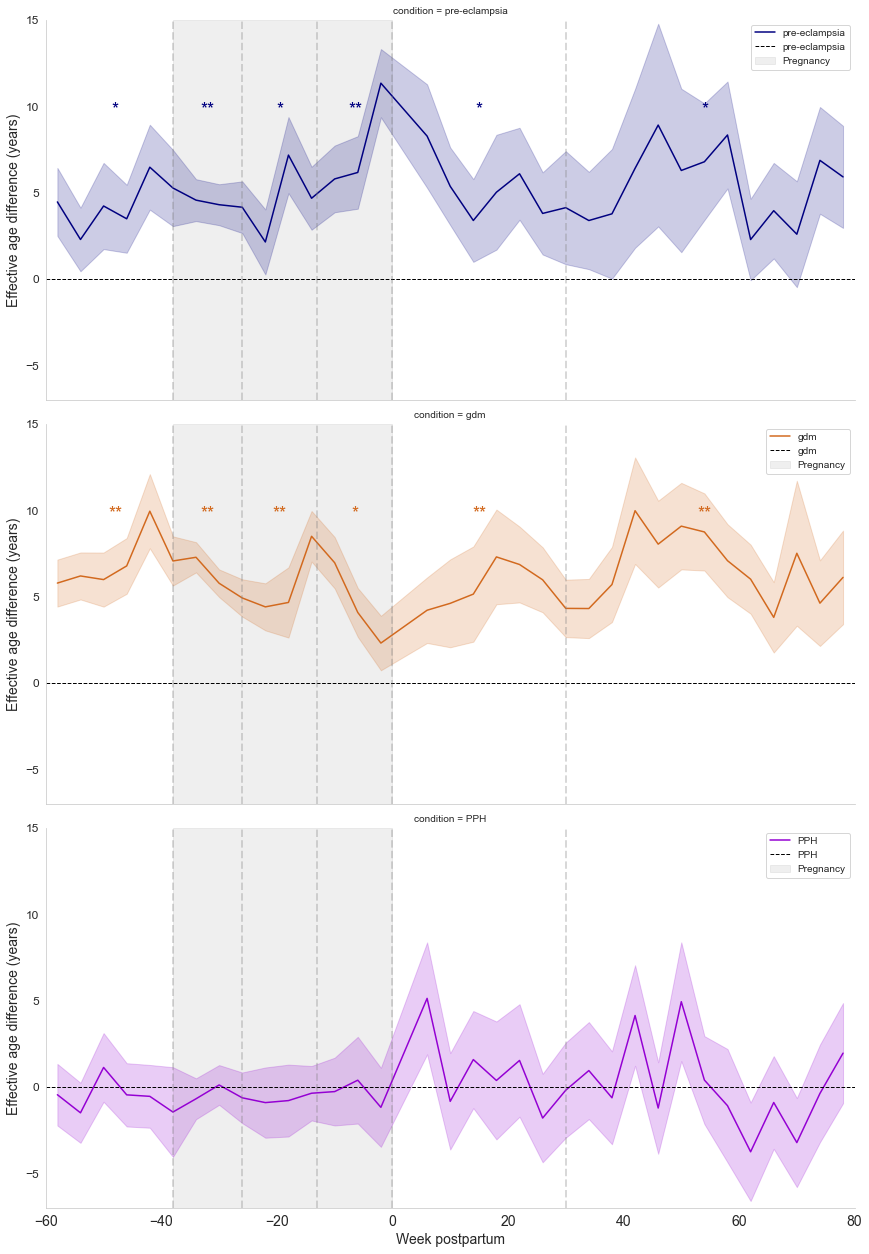

In [24]:
from preg_aging.plotting import plot_age_acceleration_by_lin_reg
fig = plot_age_acceleration_by_lin_reg(comp_model,
                                       [r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.pre-eclampsia.4w",
                                        r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w",
                                        r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.postpartum_hemorrhage.4w"],
                                       r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w",
                                       exclude_points=[2], compared_color_map={r"pre-eclampsia": "navy",
                                                                               "gdm": "chocolate",
                                                                               "PPH": "darkviolet"},
                                       p_val_bins=[-58, -38, -26, -13, 0, 30, 78], use_fill=True, y_limit=[-7, 15],
                                       y_ticks=[-5, 0, 5, 10, 15], fix_outliers=True)

# fig.savefig(os.path.join("graphs", "age_acceleration_comp_5_diff.svg"))


NameError: name 'get_clalit_data' is not defined

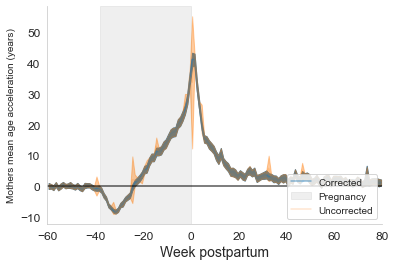

In [26]:
from preg_aging.plotting import plot_model_prediction
f, ax = plot_model_prediction(model, fix_outliers=True, use_fill=True, label="Corrected")
plot_model_prediction(model, use_fill=True, ax=ax, label="Uncorrected", alpha=0.2)
pred_median = add_constant(pd.DataFrame({test: get_clalit_data(test)["val_50"] for test in tests})) @ model.params
pred_median -= pred_median.loc[-60:-40].mean()
ax.plot(pred_median.index, pred_median.values, label="median")
ax.legend()
# f.savefig(os.path.join("graphs", "pregnancy_pred_full.svg"))
display(f)
####
plt.clf()
f, ax = plot_model_prediction(model, fix_outliers=True, use_fill=True)
# f.savefig(os.path.join("graphs", "pregnancy_pred.svg"))

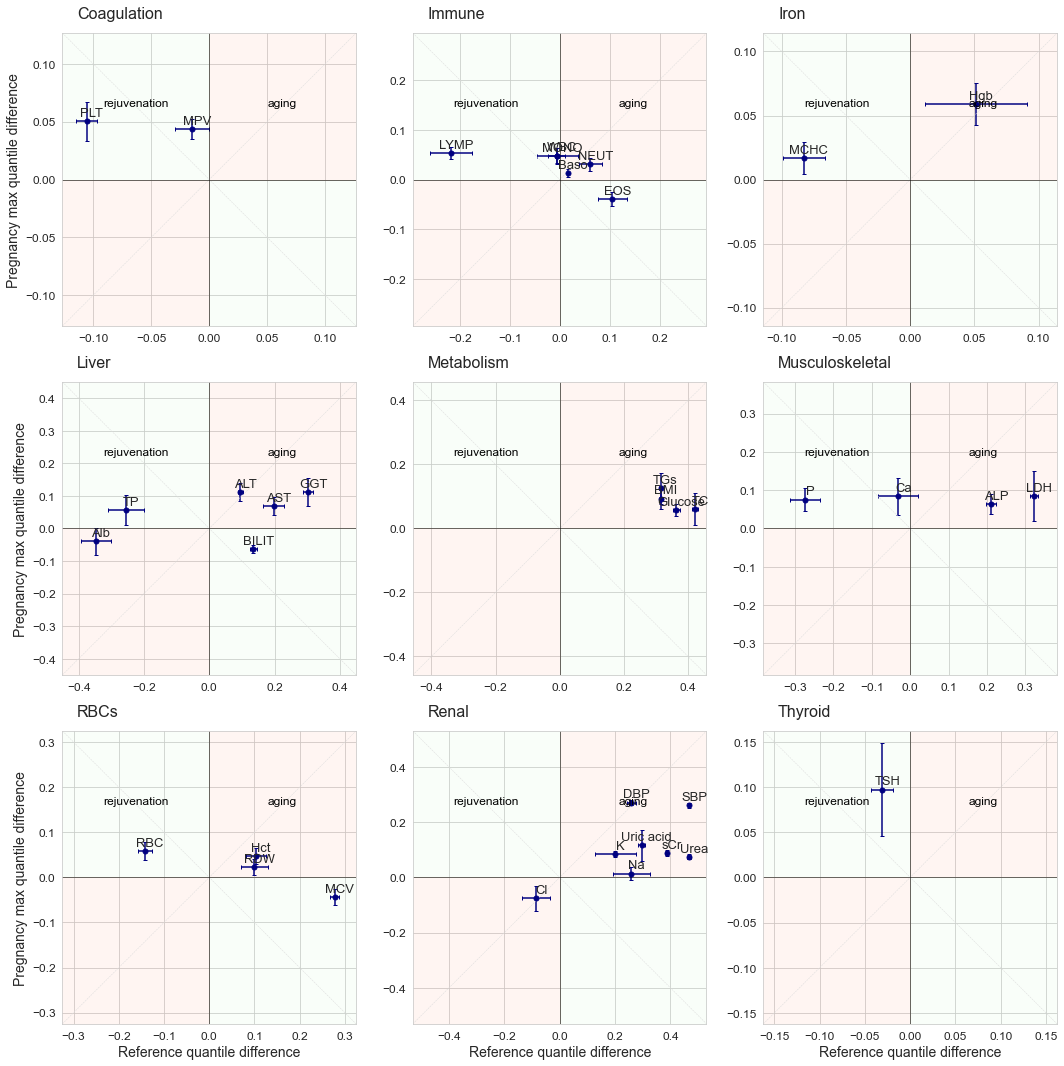

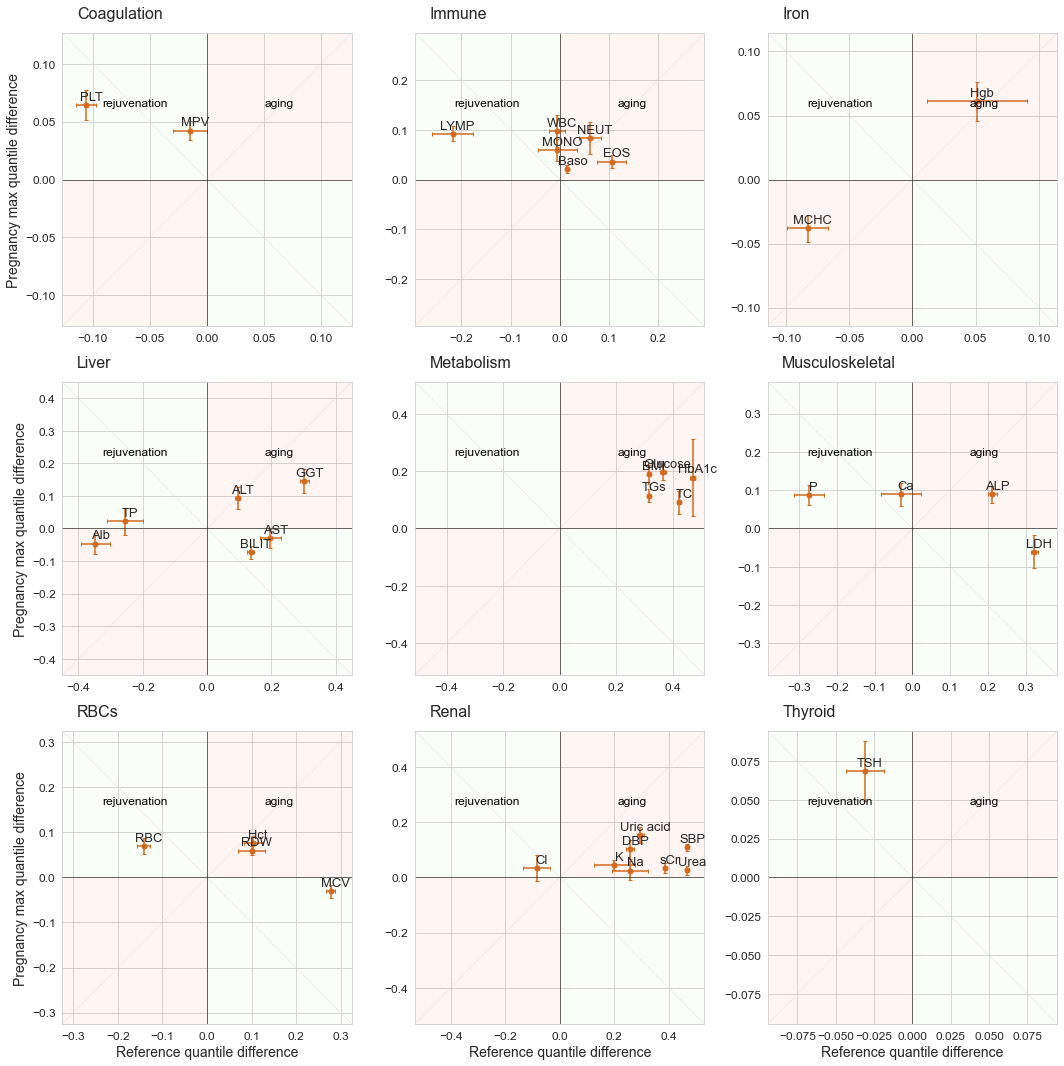

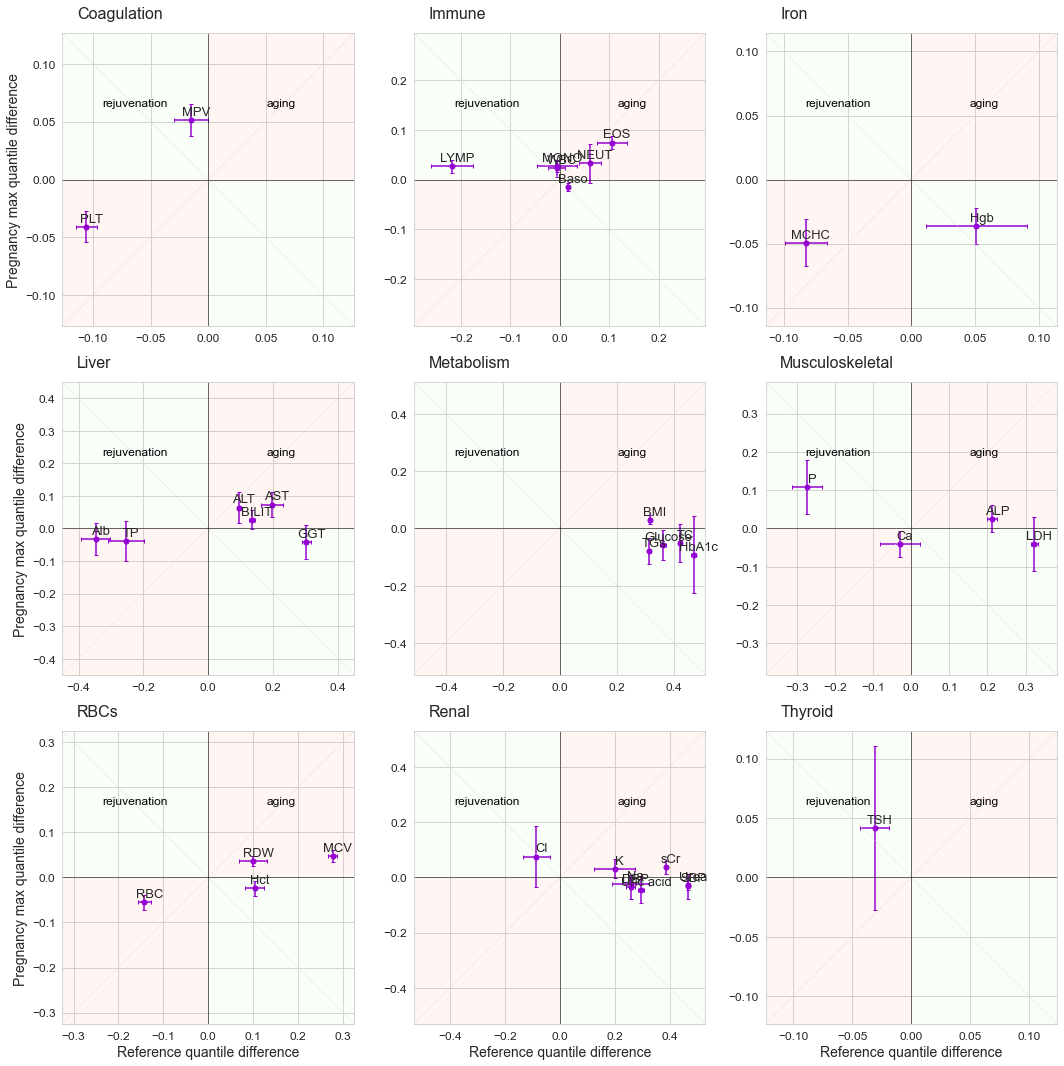

In [62]:
from preg_aging.plotting import plot_diff_grid_pathologies
complications_group = group_tests(complication_tests)
fig = plot_diff_grid_pathologies(complications_group,
                                 r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.pre-eclampsia.4w",
                                 r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="navy")
plt.tight_layout()
fig.savefig(os.path.join("graphs", "quantile diff, preecl.svg"))

fig = plot_diff_grid_pathologies(complications_group, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w",
                                 r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="chocolate")
plt.tight_layout()
fig.savefig(os.path.join("graphs", "quantile diff, gdm.svg"))

fig = plot_diff_grid_pathologies(complications_group,
                                 r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.postpartum_hemorrhage.4w",
                                 r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="darkviolet")
plt.tight_layout()
fig.savefig(os.path.join("graphs", "quantile diff, pph.svg"))

## Regression weight visualization

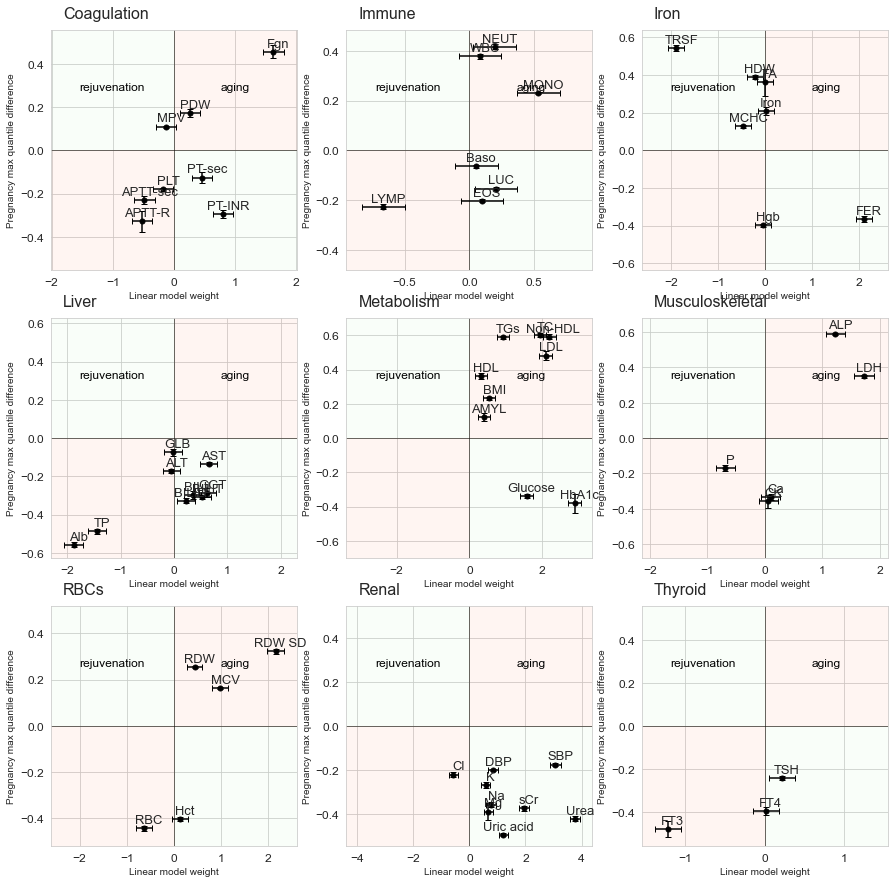

In [33]:
from preg_aging.plotting import plot_diff_grid_model_weights
_ = plot_diff_grid_model_weights(test_groups, norm_model)

C:\Users\ronmo\PycharmProjects\PregAging\src\preg_aging\plotting.py:587: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return fig
C:\Users\ronmo\PycharmProjects\PregAging\src\preg_aging\plotting.py:587: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return fig


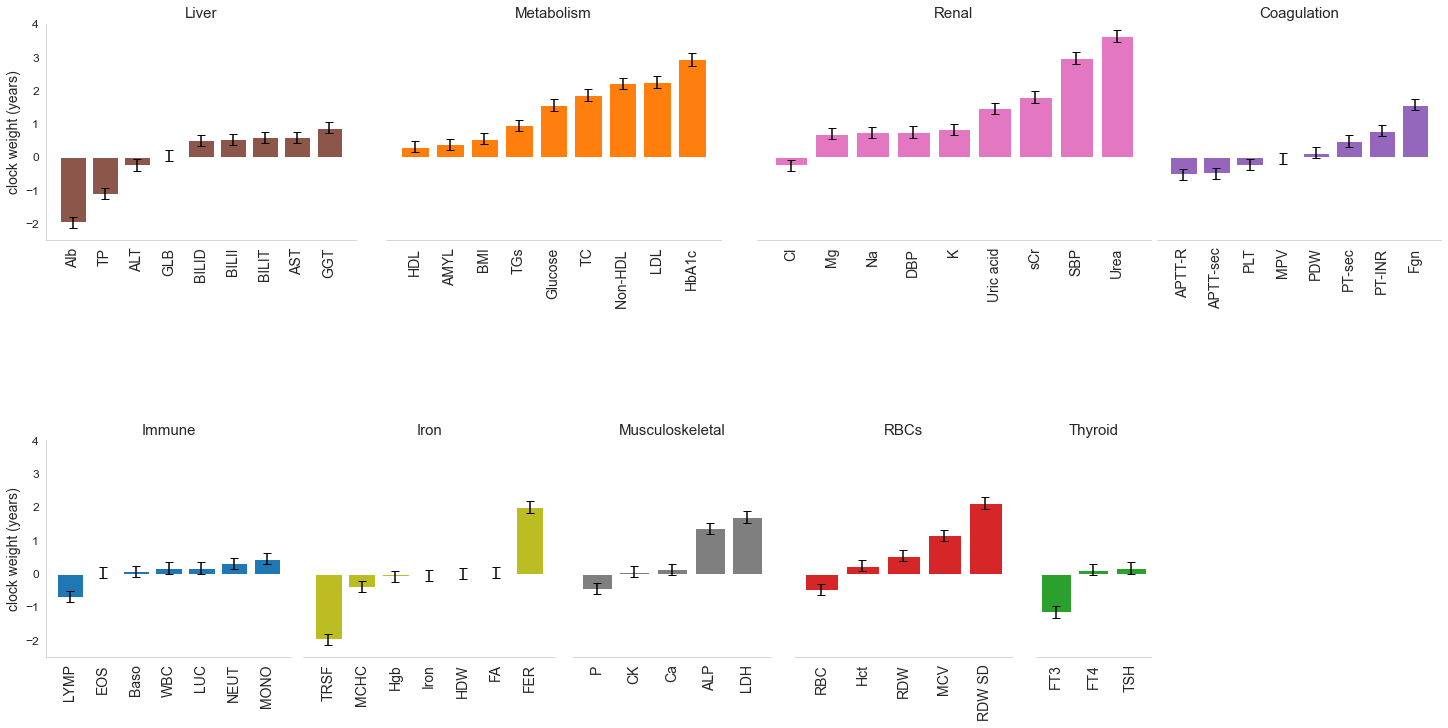

In [123]:
from preg_aging.plotting import plot_model_weights
color_map = {'Immune': '#1f77b4', "Metabolism": '#ff7f0e', "Thyroid": '#2ca02c', "RBCs": '#d62728', "Coagulation": '#9467bd', "Liver": '#8c564b', "Renal": '#e377c2', "Musculoskeletal": '#7f7f7f', "Iron": '#bcbd22'}
f = plot_model_weights(test_groups, norm_model, color_map, 4, [-2.5,4])
f.savefig(os.path.join("graphs", "model_weights.svg"))
f.savefig(os.path.join("graphs", "model_weights.png"), dpi=150)

<Figure size 432x288 with 0 Axes>

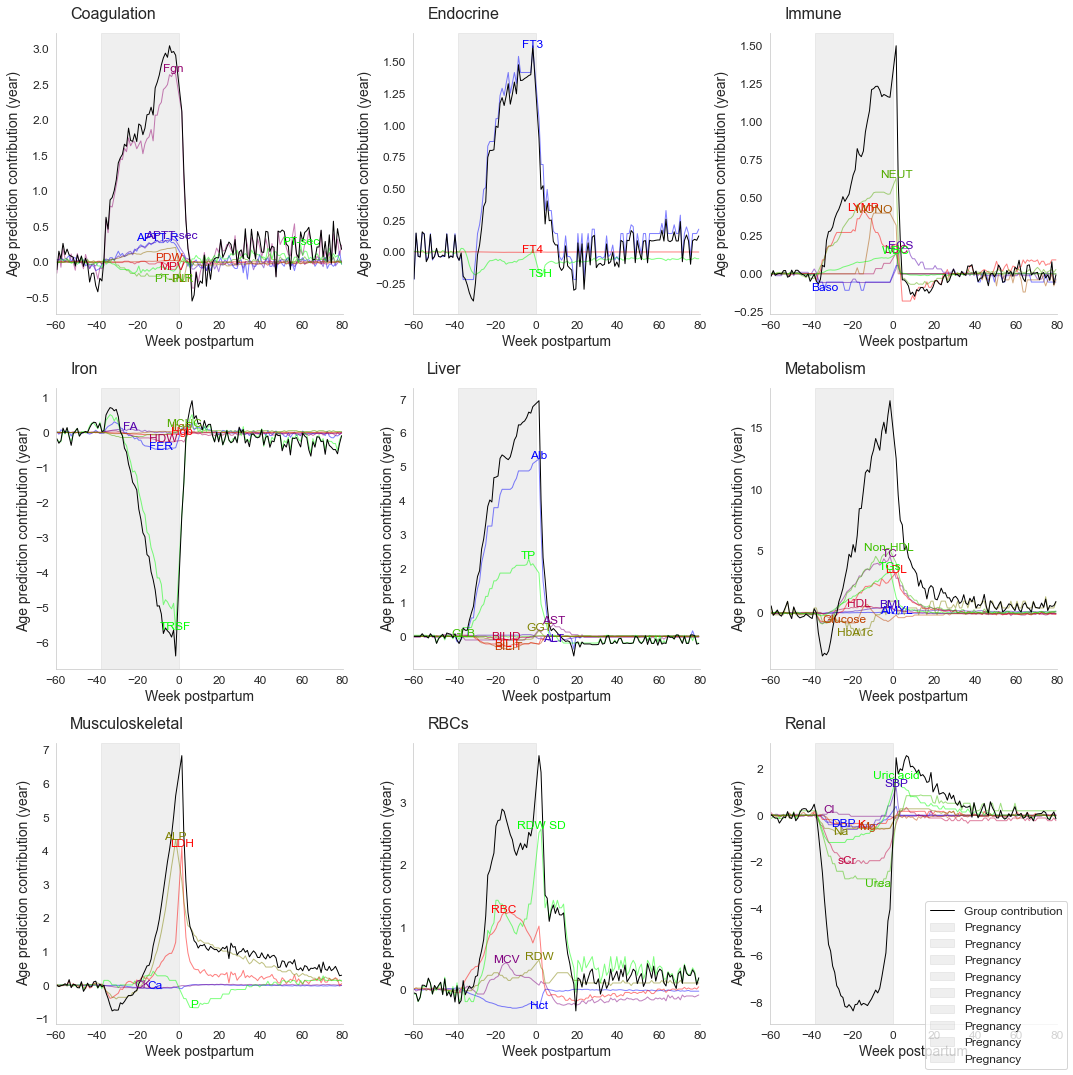

In [57]:
from preg_aging.plotting import plot_groups_linear_prediction
plt.clf()
test_groups_rbc_comp = test_groups.copy()
fig, _ = plot_groups_linear_prediction(test_groups, model.params, skip_range=[-1., 1.], colormap="brg")
plt.tight_layout()
fig.savefig(os.path.join("graphs", "system_by_system_prediction.svg"))

## Check high varaince

In [5]:
from preg_aging.clalit_parser import get_clalit_data, translate_long_to_short_lab
import pandas as pd
s = pd.Series(data=-1, index=tests, dtype=float, name="SEM ratio")
for t in tests:
    df = get_clalit_data(t)
    df = df.loc[~df.index.isin([-0.5, 0.5])]
    sem = df["val_sd"] / df["val_n"] ** 0.5
    s.loc[t] = sem.max() / sem.median()
(s  * 1).sort_values(ascending=False, key=abs)

CK_CREAT            279.192052
BMI                 126.405075
LYMP                 29.648884
FERRITIN             23.534697
APTT_R               18.679031
                       ...    
MPV                   1.317459
RDW                   1.313888
GLOBULIN              1.310586
MCV                   1.303323
PHOSPHORUS_BLOOD      1.165880
Name: SEM ratio, Length: 62, dtype: float64